This notebook compares the performance of different distributed estimation algorithms :<br>
KCF (Kalman Consensus Filter, 2007)<br>
ICF (Information Consensus Filter, 2013)<br>

In [1]:
import os
import settings.input

# Choose target and sensor-network
input_files = []
input_files.append(os.path.join("settings","json_files", "target-rotating.json"))
input_files.append(os.path.join("settings","json_files", "test-network-1.json"))

# Read input files
input_data = settings.input.read(input_files)

Consider a network of sensors connected as,

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


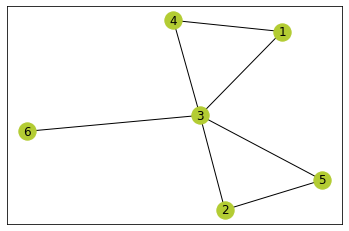

In [2]:
from sim.helpers import show_graph
show_graph(input_data["network"]["adjacency"])

Consider the scenario where sensors `'1'`, `3` and `4` have high estimation error; We expect this to cause poor performance at sensor `'3'`, for distributed estimation protocols that do not weight their neighbors' information (such as the Kalman Consensus Filter). 

In [3]:
input_data["network"]["noise_covariances"]["1"] = [[10000, 0], [0, 10000]]
input_data["network"]["noise_covariances"]["3"] = [[10000, 0], [0, 10000]]
input_data["network"]["noise_covariances"]["4"] = [[10000, 0], [0, 10000]]

Consider a target moving in circles (with system noise) being observed by our sensor network. <br>
We compare the performance of KCF (Kalman Consensus Filter) & ICF (Information Consensus Filter) :

In [ ]:
from sim.simulation import simulate_many
sensor_initials = {"estimate_prior": [[100], [40]],
                   "ErrCov_prior": [[50,0],[0,50]]}

results = simulate_many(input_data, duration = 3, est_schemes=["KCF-WC"], 
                        sensor_initials=sensor_initials)
print("KCF Scheme (Poor performance) : ")
results[0].plot_xy(target=True, estimates_of="3")
# print("ICF Scheme (Better performance) : ")
# results[1].plot_xy(target=True, estimates_of="3")

Warning, the scheme KCF-WC is not fully distributed.
Initializing a sensor network with KCF-WC scheme...
Simulating for 3 time-steps...
--Return--
> /Users/shiraz/repos/sensor-network-sim/sim/estimators/KCF_WC.py(49)do_estimation()->None
-> import pdb; pdb.set_trace()
(Pdb) A
[[array([[0., 0.],
       [0., 0.]]), array([[0., 0.],
       [0., 0.]])], [array([[0., 0.],
       [0., 0.]]), array([[0., 0.],
       [0., 0.]])]]
(Pdb) B
[array([[0., 0.],
       [0., 0.]]), array([[0., 0.],
       [0., 0.]])]
(Pdb) C
[array([[0., 0.],
       [0., 0.]]), array([[0., 0.],
       [0., 0.]])]
(Pdb) self.neighbors
['3', '4']
(Pdb) A[0]
[array([[0., 0.],
       [0., 0.]]), array([[0., 0.],
       [0., 0.]])]
(Pdb) A[0][0]
array([[0., 0.],
       [0., 0.]])
(Pdb) B[0]
array([[0., 0.],
       [0., 0.]])
(Pdb) np.block(A) @ np.block(C)
*** ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 4)
(Pdb) np.block(

In [ ]:
###### Estimated Error Covariance
# print("Estimated Error Covariance of sensor 3, using KCF :")
# results[0].plot_timeseries(ErrCov_of="3")
# print("Estimated Error Covariance of sensor 3, using ICF :")
# results[1].plot_timeseries(ErrCov_of="3")

Since the sensor network operates via its own classobjects, we can simulate two estimation schemes concurrently and compare their performances. <br>
To simulate a single estimation scheme, use `sim.simulation.simulate`.